In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
from scipy.stats import t
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score

from ploter import visualize_all

### Исследование неопределенности модели с помощью MC Dropout

### Цель работы
Цель — проанализировать поведение модели бинарной классификации при использовании метода Монте-Карло Dropout. Исследуется, как различное значение `dropout` влияет на точность (`accuracy`), устойчивость (`f1-score`) и форму распределений вероятностей выхода модели.


### Описание данных
Использованы синтетические наборы данных:
- **Moons** - два полукольца, зашумлённые на границе
- **Circles** - вложенные окружности с добавленным шумом

Каждый датасет разбивается на `train`, `val`, а также `mini_test` - 6 примеров одного класса, предназначенные для визуализации распределения предсказаний.


### Методы
- **MC Dropout** активирует Dropout во время инференса для аппроксимации байесовской неопределенности.
- В каждой эпохе считаются:
  - `eval` метрики (точность и f1)
  - `mc_eval` с $T = 1000$ сэмплами
  - распределения вероятностей на `mini_test`

Дополнительно проводится **поиск по сетке гиперпараметров** (размер скрытых слоев, LR, batch size) для выбора оптимальной архитектуры.


### Оценка качества
Модель оценивается по:
- **Accuracy** и **F1-score**
- **Доверительным интервалам** (бутстрап)
- **Entropy**, **Variance**, **Margin (|p - 0.5|)** на mini_test
- Визуализации распределений (гистограммы, violin)

### 1 Генерация синтетических данных

In [2]:
def _split_and_scale(X, y, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    scaler = StandardScaler().fit(X_train)
    X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

    rng = np.random.default_rng(seed=random_state)
    majority = 0 if (y == 0).sum() >= (y == 1).sum() else 1
    mini_candidates = np.where(y_test == majority)[0]
    mini_idx = rng.choice(mini_candidates, size=6, replace=False)
    X_mini, y_mini = X_test[mini_idx], y_test[mini_idx]

    make_tensor = lambda arr: torch.tensor(arr, dtype=torch.float32)
    return dict(
        train=(make_tensor(X_train), torch.tensor(y_train)),
        test=(make_tensor(X_test), torch.tensor(y_test)),
        mini_test=(make_tensor(X_mini), torch.tensor(y_mini)),
    )


def make_binary_datasets(
    n_samples: int = 2000,
    noise: float = 0.25,
    test_size: float = 0.3,
    random_state: int = 0,
):
    X_moons, y_moons = make_moons(
        n_samples=n_samples, noise=noise, random_state=random_state
    )
    X_circ, y_circ = make_circles(
        n_samples=n_samples, noise=noise / 2, factor=0.4, random_state=random_state
    )

    return {
        "moons": _split_and_scale(X_moons, y_moons, test_size, random_state),
        "circles": _split_and_scale(X_circ, y_circ, test_size, random_state),
    }

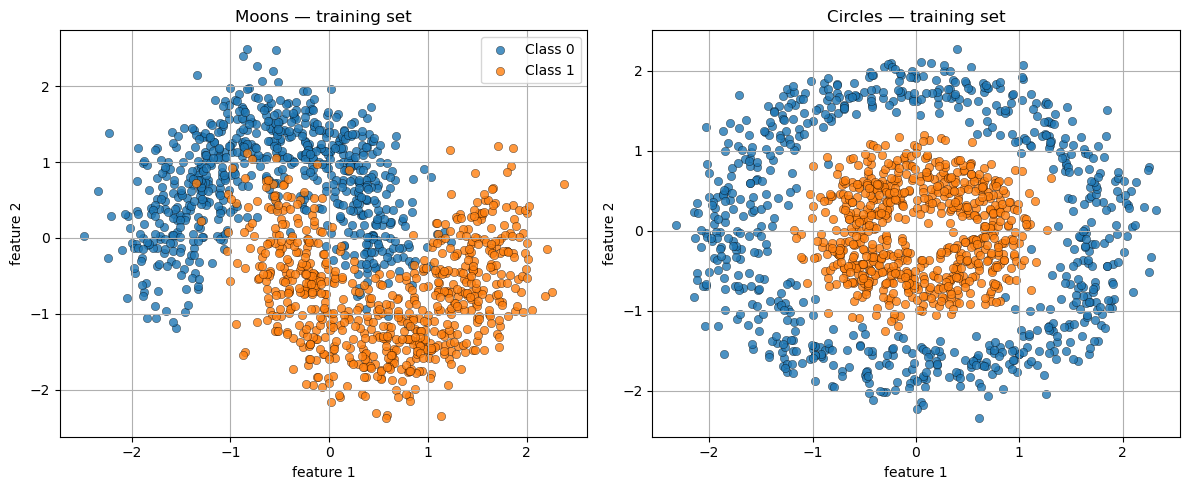

In [3]:
splits = make_binary_datasets()

fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharex=False, sharey=False)

for subplot, name in enumerate(["moons", "circles"]):
    X_train, y_train = splits[name]["train"]

    X = X_train.numpy() if hasattr(X_train, "numpy") else X_train
    y = y_train.numpy() if hasattr(y_train, "numpy") else y_train

    for cls in np.unique(y):
        m = y == cls
        ax[subplot].scatter(
            X[m, 0],
            X[m, 1],
            label=f"Class {cls}",
            alpha=0.8,
            edgecolors="k",
            linewidths=0.3,
        )

    ax[subplot].set_title(f"{name.capitalize()} — training set")
    ax[subplot].set_xlabel("feature 1")
    ax[subplot].set_ylabel("feature 2")
    ax[subplot].grid(True)


ax[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

In [4]:
def make_loaders(splits: dict, batch_size: int = 64, shuffle_train: bool = True):
    X_tr, y_tr = splits["train"]
    X_val, y_val = splits["test"]

    train_ds = TensorDataset(X_tr, y_tr)
    val_ds   = TensorDataset(X_val, y_val)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=shuffle_train, drop_last=False
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    return train_loader, val_loader

In [5]:
loaders = {
    name: make_loaders(ds_splits, batch_size=64)
    for name, ds_splits in splits.items()
}

train_loader_moons, val_loader_moons = loaders["moons"]
train_loader_circles, val_loader_circles = loaders["circles"]

In [6]:
mini_moons, mini_moons_labels = splits['moons']['mini_test']
mini_circles, mini_circles_labels = splits['circles']['mini_test']

### 2 MLP

In [7]:
class MLP(nn.Module):
    def __init__(
        self,
        in_dim: int = 2,
        hidden_sizes = (64, 64),
        n_classes: int = 1,
        activation: str = "relu",
        dropout_p: float = 0.3,
        batchnorm: bool = False,
    ):
        super().__init__()
        acts = dict(relu=nn.ReLU, tanh=nn.Tanh, gelu=nn.GELU)
        act = acts[activation.lower()]

        layers = []
        last = in_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(last, h))
            if batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(act())
            layers.append(nn.Dropout(dropout_p))
            last = h
        layers.append(nn.Linear(last, n_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [8]:
param_grid = {
    "hidden_sizes": [
        (32, 32),
        (64, 64),
        (128, 64),
        (128, 128),
        (256, 128, 64),
    ],
    "activation": ["relu", "tanh", "gelu"],
    "dropout_p": [0.2, 0.3, 0.5],
    "batchnorm": [False, True]
}

### 3 Поиск лучших гиперпараметров

In [9]:
def train_epoch(model, loader, criterion, optimizer, device="cpu"):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits.squeeze(), y.float() if logits.shape[1] == 1 else y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        preds = (logits.sigmoid() > 0.5) if logits.shape[1] == 1 else logits.argmax(1)
        correct += (preds.squeeze() == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


@torch.inference_mode()
def eval_model(model, loader, device="cpu"):
    model.eval()
    all_y, all_pred = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        preds = (logits.sigmoid() > 0.5) if logits.shape[1]==1 else logits.argmax(1)
        all_y.append(y.cpu())
        all_pred.append(preds.squeeze().cpu())
    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_pred).numpy()

    return {
        'acc': accuracy_score(y_true, y_pred),
        'f1_micro': f1_score(y_true, y_pred, average="micro"),
        'f1_macro': f1_score(y_true, y_pred, average="macro"),
        'f1_weighted': f1_score(y_true, y_pred, average="weighted"),
    }

In [10]:
@torch.inference_mode()
def eval_model(model, loader, device="cpu"):
    model.eval()
    all_y, all_pred = [], []
    for X, y in loader:
        X = X.to(device)
        logits = model(X)
        preds = (logits.sigmoid() > 0.5) if logits.shape[1]==1 else logits.argmax(1)
        all_y.append(y.cpu())
        all_pred.append(preds.squeeze().cpu())
    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_pred).numpy()

    return {
        'acc': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred, average="binary"),
    }

In [11]:
def grid_search_trainer(
    train_loader,
    val_loader,
    in_dim,
    n_classes,
    param_grid,
    n_epochs = 15,
    lr = 1e-3,
    weight_decay = 0.0,
    device = "cpu",
    score_key = "f1_macro"
):

    best_score = -float("inf")
    best_params = {}
    best_state_dict = None

    all_configs = list(ParameterGrid(param_grid))

    for i, cfg in tqdm(enumerate(all_configs, 1)):
        model = MLP(in_dim=in_dim, n_classes=n_classes, **cfg).to(device)

        if n_classes == 1:
            criterion = nn.BCEWithLogitsLoss()
        else:
            criterion = nn.CrossEntropyLoss()

        optimizer = torch.optim.Adam(
            model.parameters(), lr=lr, weight_decay=weight_decay
        )

        for epoch in range(1, n_epochs + 1):
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device
            )
        
        val_metrics = eval_model(model, val_loader, device)
        val_score = val_metrics[score_key]

        if val_score > best_score:
            best_score = val_score
            best_params = deepcopy(cfg)
            best_state_dict = deepcopy(model.state_dict())

    best_model = MLP(in_dim=in_dim, n_classes=n_classes, **best_params).to(device)
    best_model.load_state_dict(best_state_dict)

    print(f"Лучшие параметры: {best_params}")
    print(f"Лучший {score_key}: {best_score:.4f}")

    return best_model, best_params, best_score

* Поиск гиперпараметров для датасета moons

In [12]:
best_model, best_params, best_score = grid_search_trainer(
    train_loader=train_loader_moons,
    val_loader=val_loader_moons,
    in_dim=X_train.shape[1],
    n_classes=1,
    param_grid=param_grid,
    n_epochs=5,
    lr=1e-3,
    weight_decay=1e-4,
    device="cuda",
    score_key="f1"
)

90it [00:57,  1.57it/s]

Лучшие параметры: {'activation': 'relu', 'batchnorm': True, 'dropout_p': 0.3, 'hidden_sizes': (256, 128, 64)}
Лучший f1: 0.9312


* Поиск гиперпараметров для датасета circles

In [13]:
best_model, best_params, best_score = grid_search_trainer(
    train_loader=train_loader_circles,
    val_loader=val_loader_circles,
    in_dim=X_train.shape[1],
    n_classes=1,
    param_grid=param_grid,
    n_epochs=5,
    lr=1e-3,
    weight_decay=1e-4,
    device="cuda",
    score_key="f1"
)

90it [00:48,  1.84it/s]

Лучшие параметры: {'activation': 'relu', 'batchnorm': True, 'dropout_p': 0.2, 'hidden_sizes': (128, 128)}
Лучший f1: 0.9950


### MC Dropout

In [14]:
def eval_mc_dropout(model, loader, T=1000, device="cpu", alpha=0.05):
    model.train()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            preds_T = []
            for _ in range(T):
                logits = model(X_batch)
                probs = torch.sigmoid(logits).squeeze()
                preds = (probs > 0.5).int().cpu().numpy()
                preds_T.append(preds)

            preds_T = np.stack(preds_T, axis=0)
            preds_mean = np.mean(preds_T, axis=0)
            preds_majority = (preds_mean > 0.5).astype(int)

            all_preds.append(preds_majority)
            all_targets.append(y_batch.cpu().numpy())

    y_true = np.concatenate(all_targets)
    y_pred = np.concatenate(all_preds)

    def bootstrap_metric(metric_fn, y_true, y_pred, n_iter=1000):
        n = len(y_true)
        stats = []
        rng = np.random.default_rng(42)
        for _ in range(n_iter):
            idx = rng.integers(0, n, n)
            score = metric_fn(y_true[idx], y_pred[idx])
            stats.append(score)
        mean = np.mean(stats)
        std_err = np.std(stats, ddof=1)
        ci_halfwidth = t.ppf(1 - alpha / 2, df=n_iter - 1) * std_err
        return {
            "mean": mean,
            "ci": (mean - ci_halfwidth, mean + ci_halfwidth),
        }

    return {
        "accuracy": bootstrap_metric(accuracy_score, y_true, y_pred),
        "f1": bootstrap_metric(lambda yt, yp: f1_score(yt, yp, average="binary"), y_true, y_pred),
    }

In [15]:
def mc_eval_mini(model, X_mini, y_mini, T=10_000, device="cpu"):
    model.train()
    X_mini = X_mini.to(device)
    
    probs_T = []

    with torch.no_grad():
        for _ in range(T):
            logits = model(X_mini)
            probs = torch.sigmoid(logits).squeeze().cpu().numpy()
            probs_T.append(probs)

    probs_T = np.stack(probs_T, axis=0)

    return {
        "probs": probs_T,
        "y_true": y_mini,
    }

In [16]:
def train_model(
    model, 
    train_loader, 
    val_loader,
    X_mini,
    y_mini, 
    criterion, 
    optimizer, 
    n_epochs=10, 
    device="cpu", 
    use_mc_dropout=True, 
    mc_T=1000
):
    history = []

    for epoch in range(1, n_epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = eval_model(model, val_loader, device)
        proba = mc_eval_mini(model, X_mini, y_mini, device=device)

        epoch_info = {
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_acc": val_metrics["acc"],
            "val_f1": val_metrics["f1"],
            "mini_proba": proba['probs'],
            "mini_labels": proba['y_true']
        }

        if use_mc_dropout:
            mc_metrics = eval_mc_dropout(model, val_loader, T=mc_T, device=device)
            for key, value in mc_metrics.items():
                epoch_info[f"mc_{key}_mean"] = value["mean"]
                epoch_info[f"mc_{key}_ci_low"] = value["ci"][0]
                epoch_info[f"mc_{key}_ci_high"] = value["ci"][1]

        history.append(epoch_info)

        print(f"[Epoch {epoch:02d}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"→ Val Acc: {val_metrics['acc']:.4f} | F1: {val_metrics['f1']:.4f}")
        if use_mc_dropout:
            print(
                f"→ MC-Dropout Acc: {mc_metrics['accuracy']['mean']:.4f} "
                f"(CI: [{mc_metrics['accuracy']['ci'][0]:.4f}, {mc_metrics['accuracy']['ci'][1]:.4f}])"
            )
    return history

In [17]:
def run_dropout_sweep(dropout_values, model_fn, train_loader, val_loader, X_mini, y_mini,
                      criterion_fn, optimizer_fn, n_epochs=10, device="cpu", mc_T=1000):
    results = []

    for p in dropout_values:
        print(f"\n== Training with Dropout p={p} ==")
        model = model_fn(p).to(device)
        optimizer = optimizer_fn(model.parameters())

        history = []
        for epoch in range(1, n_epochs + 1):
            model.train()
            train_loss, train_acc = train_epoch(model, train_loader, criterion_fn, optimizer, device)
            val_metrics = eval_model(model, val_loader, device)
            mc_metrics = eval_mc_dropout(model, val_loader, T=mc_T, device=device)
            mini_eval = mc_eval_mini(model, X_mini, y_mini, T=mc_T, device=device)

            history.append({
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_acc": val_metrics["acc"],
                "val_f1": val_metrics["f1"],
                "mc_val_acc": mc_metrics["accuracy"]["mean"],
                "mc_val_f1": mc_metrics["f1"]["mean"],
                "mini_proba": mini_eval["probs"],
                "mini_labels": mini_eval["y_true"],
            })

        results.append({"dropout": p, "history": history})

    # График: обычная vs MC Accuracy/F1
    plt.figure(figsize=(10, 6))
    for result in results:
        p = result["dropout"]
        hist = result["history"]
        val_acc = [h["val_acc"] for h in hist]
        mc_acc = [h["mc_val_acc"] for h in hist]
        plt.plot(val_acc, label=f"Eval Acc (p={p})", linestyle="--", marker="o")
        plt.plot(mc_acc, label=f"MC Eval Acc (p={p})", linestyle="-", marker="x")
    plt.title("Val Accuracy vs MC Accuracy across Dropouts")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(2, 3, figsize=(18, 8), sharey=True)
    for i in range(6):
        ax = axs[i // 3, i % 3]
        for result in results:
            probs = result["history"][-1]["mini_proba"][:, i]
            p = result["dropout"]
            ax.hist(probs, bins=40, alpha=0.4, label=f"p={p}", histtype='step', density=True)
        ax.set_title(f"Sample {i} (Label={results[0]['history'][-1]['mini_labels'][i]})")
        ax.set_xlim(0, 1)
        ax.set_xlabel("Probability")
        ax.set_ylabel("Density")
        ax.legend(fontsize=8)

    fig.suptitle("MC Dropout Probability Distributions for 6 mini-test samples")
    plt.tight_layout()
    plt.show()

    return results

### Moons

[Epoch 01] Train Loss: 0.6211, Train Acc: 0.7336
→ Val Acc: 0.8383 | F1: 0.8463
→ MC-Dropout Acc: 0.8368 (CI: [0.8075, 0.8661])
[Epoch 02] Train Loss: 0.4371, Train Acc: 0.8657
→ Val Acc: 0.8350 | F1: 0.8431
→ MC-Dropout Acc: 0.8369 (CI: [0.8069, 0.8669])
[Epoch 03] Train Loss: 0.3294, Train Acc: 0.8679
→ Val Acc: 0.8467 | F1: 0.8544
→ MC-Dropout Acc: 0.8453 (CI: [0.8164, 0.8743])
[Epoch 04] Train Loss: 0.2958, Train Acc: 0.8757
→ Val Acc: 0.8450 | F1: 0.8531
→ MC-Dropout Acc: 0.8438 (CI: [0.8147, 0.8730])
[Epoch 05] Train Loss: 0.2933, Train Acc: 0.8814
→ Val Acc: 0.8450 | F1: 0.8526
→ MC-Dropout Acc: 0.8454 (CI: [0.8163, 0.8745])


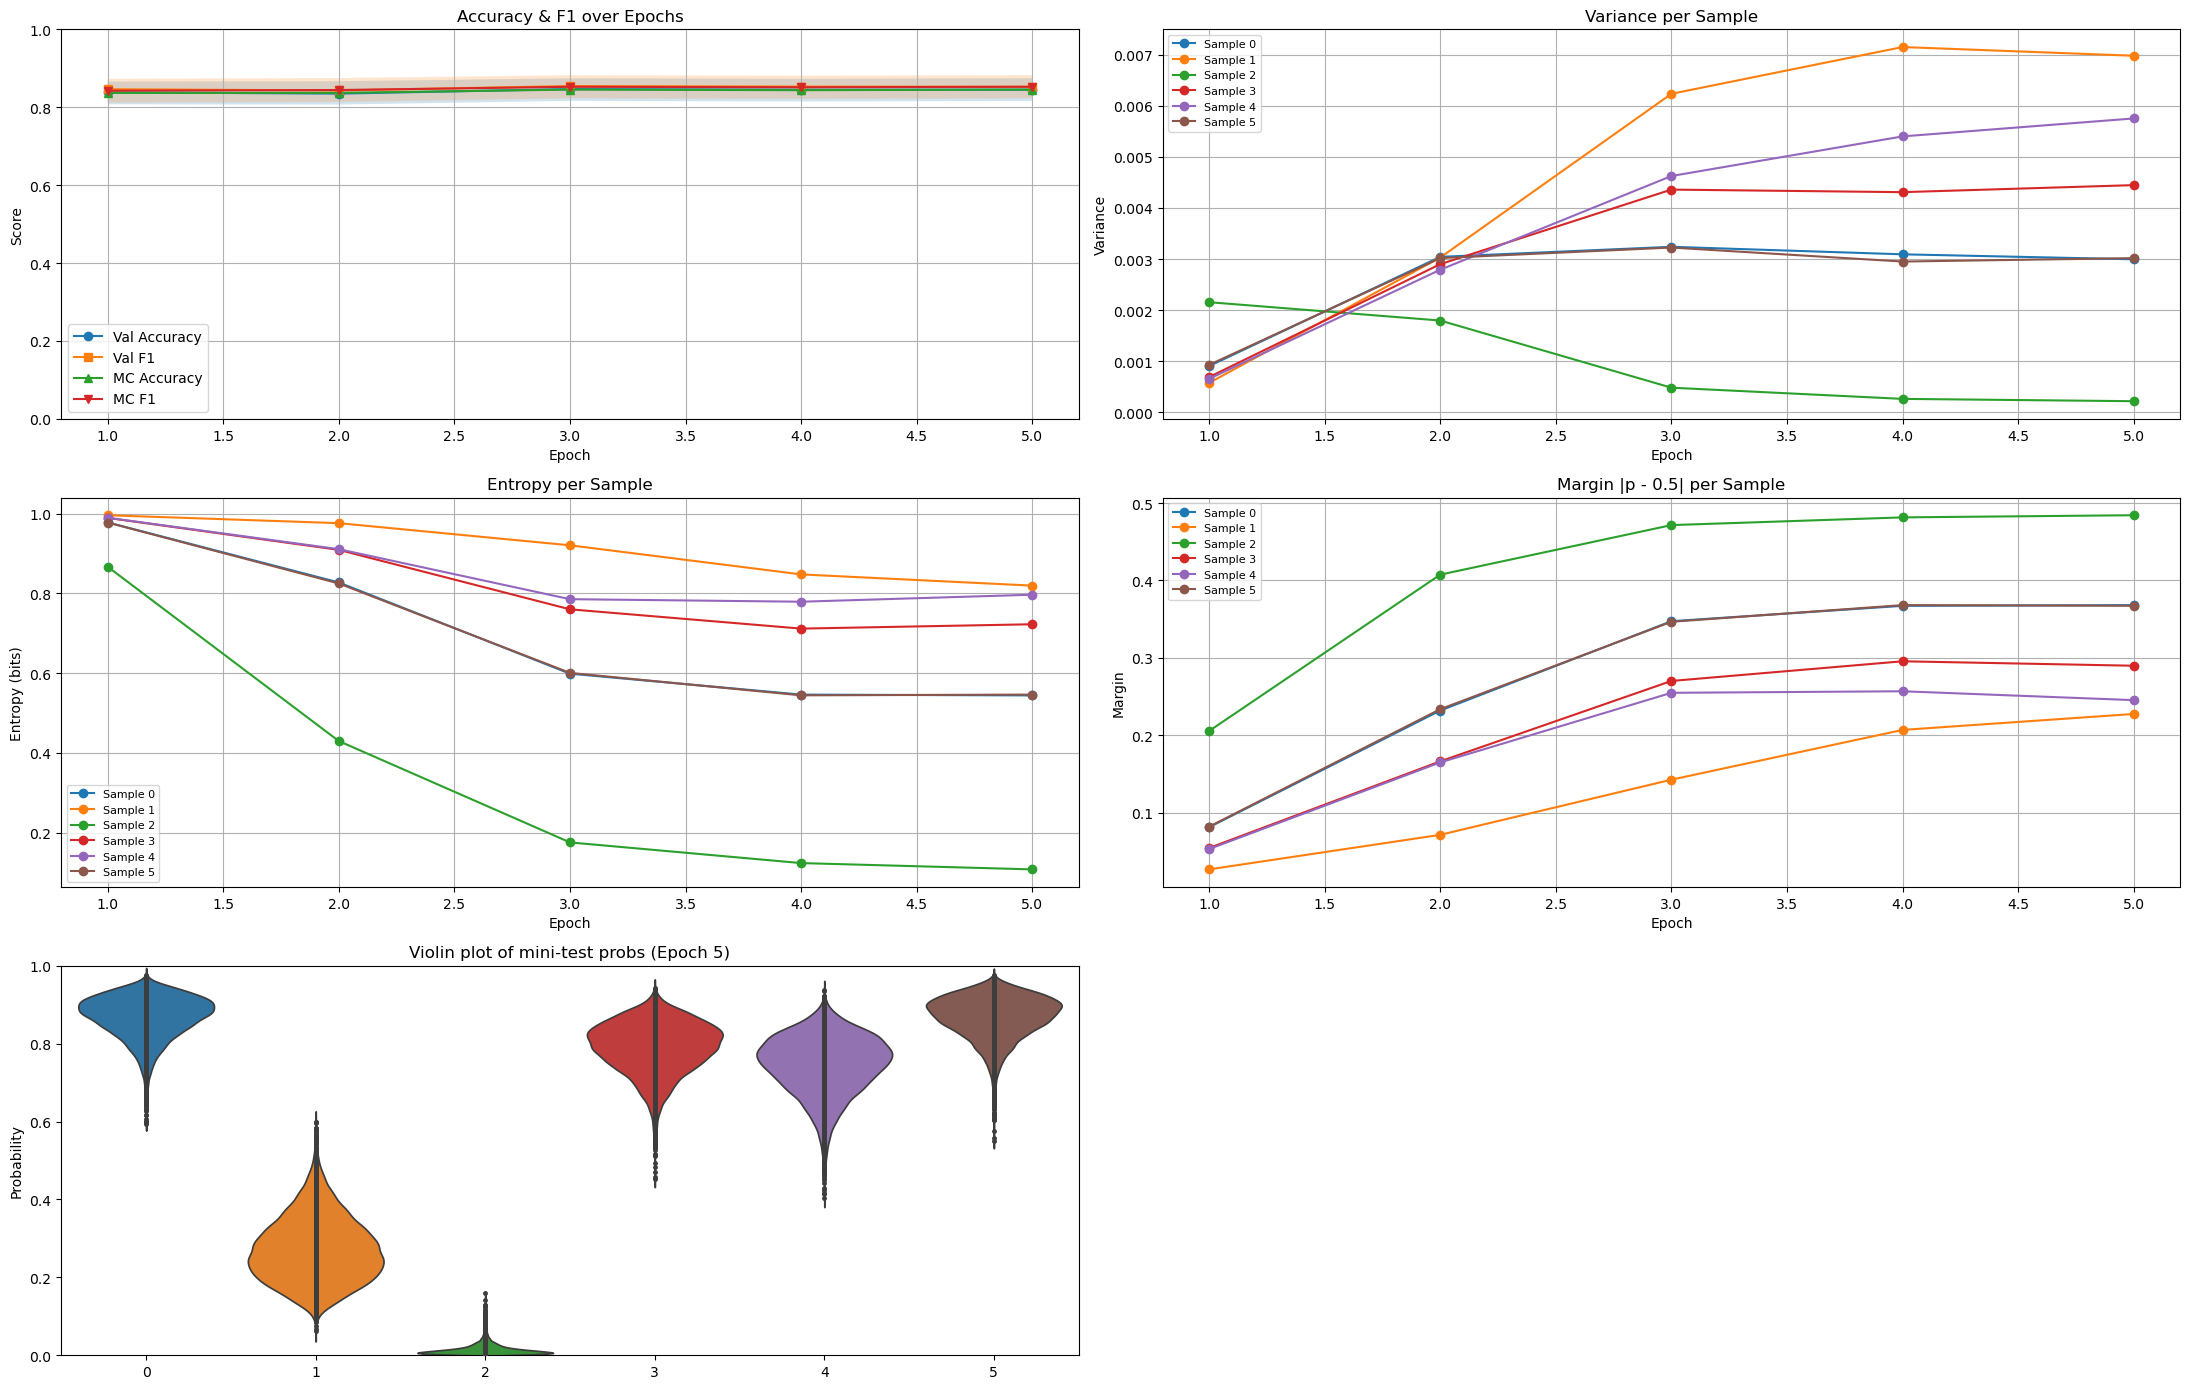

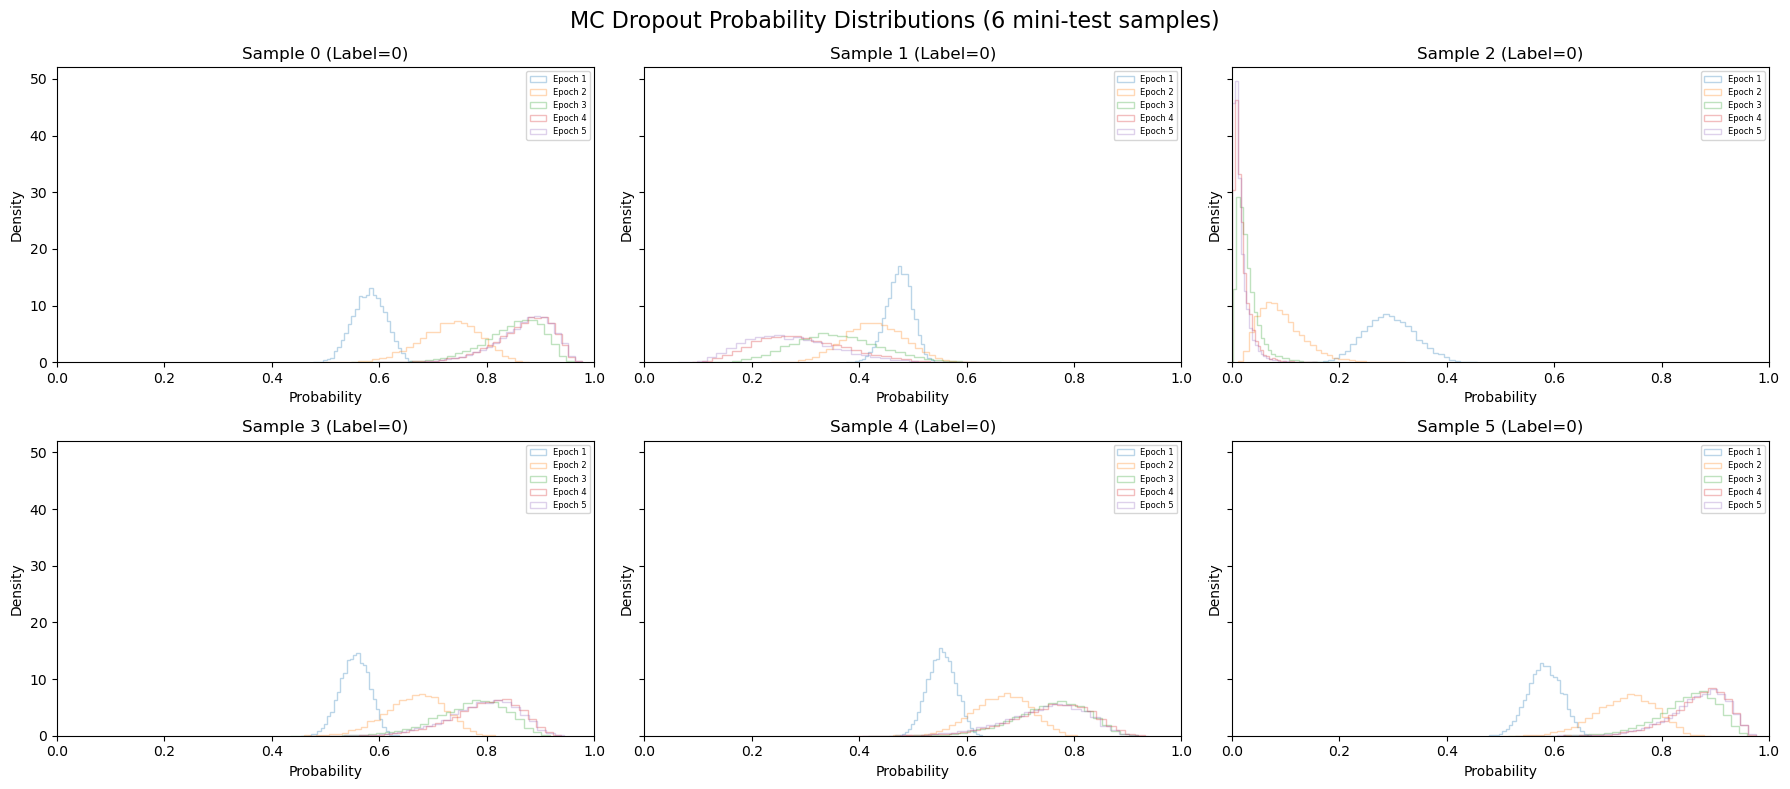

In [18]:
model = MLP().to('cuda')

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
            model.parameters(), lr=1e-3, weight_decay=0.0
        )

history = train_model(
        model, 
        train_loader_moons, 
        val_loader_moons,
        mini_moons,
        mini_moons_labels,
        criterion, 
        optimizer, 
        n_epochs=5, 
        device="cuda", 
        use_mc_dropout=True, 
        mc_T=1000
    )

visualize_all(history, model=model, val_loader=val_loader_moons, device="cuda")

**Выводы**: 

* MC Dropout позволяет точно отследить, на каких примерах модель наиболее неуверенна, даже если глобальные метрики (accuracy, f1) выглядят стабильными.

* Графики variance, entropy и margin дают согласованную картину о доверии модели к каждому примеру.

* Динамика распределений демонстрирует, как меняется форма и ширина вероятностных предсказаний, что недоступно при обычной eval.


== Training with Dropout p=0.0 ==

== Training with Dropout p=0.2 ==

== Training with Dropout p=0.4 ==

== Training with Dropout p=0.6000000000000001 ==

== Training with Dropout p=0.8 ==

== Training with Dropout p=1.0 ==


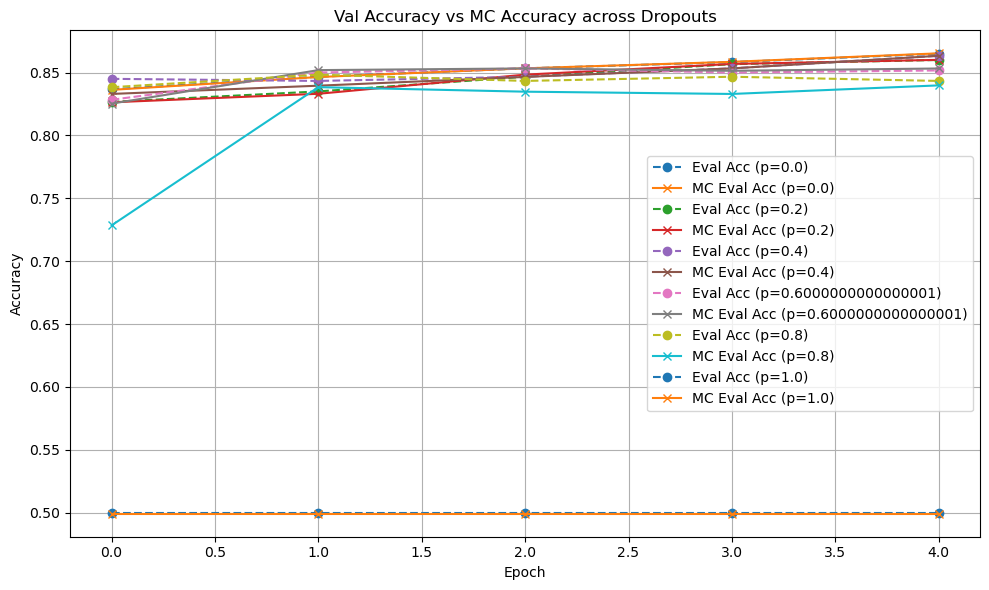

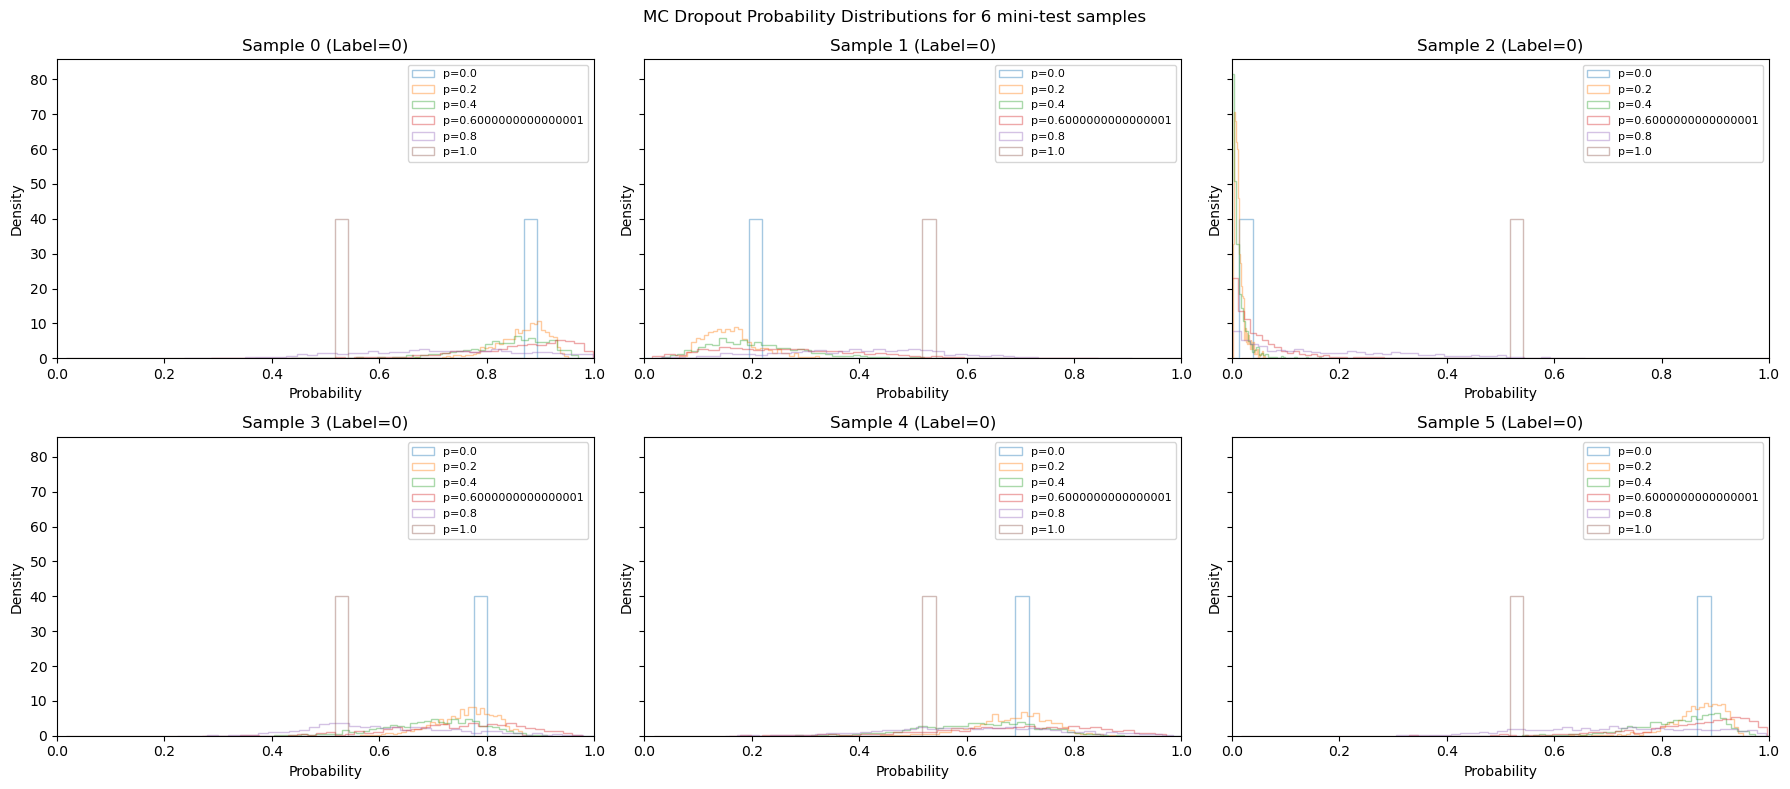

In [19]:
results = run_dropout_sweep(
    dropout_values=[0.2 * i for i in range(0, 6)],
    model_fn=lambda p: MLP(dropout_p=p),
    train_loader=train_loader_moons,
    val_loader=val_loader_moons,
    X_mini=mini_moons,
    y_mini=mini_moons_labels,
    criterion_fn=criterion,
    optimizer_fn=lambda params: torch.optim.Adam(params, lr=1e-3),
    n_epochs=5,
    device="cuda"
)

**Выводы**:

* При p=0 модель демонстрирует наивысшую уверенность, но часто переоценивает точность предсказаний.

* При p ∈ [0.2, 0.6] модель показывает наиболее адекватные и информативные распределения: присутствует вариативность, но не полная случайность.

* При p=1 = дропаут полностью разрушает детерминированность, все распределения практически равномерные, что не пригодно для оценки.

### Circles

[Epoch 01] Train Loss: 0.3820, Train Acc: 0.8879
→ Val Acc: 0.9100 | F1: 0.9011
→ MC-Dropout Acc: 0.9599 (CI: [0.9439, 0.9758])
[Epoch 02] Train Loss: 0.1713, Train Acc: 0.9664
→ Val Acc: 0.9933 | F1: 0.9933
→ MC-Dropout Acc: 0.9697 (CI: [0.9559, 0.9834])
[Epoch 03] Train Loss: 0.1337, Train Acc: 0.9607
→ Val Acc: 0.9933 | F1: 0.9933
→ MC-Dropout Acc: 0.9714 (CI: [0.9580, 0.9848])
[Epoch 04] Train Loss: 0.1166, Train Acc: 0.9600
→ Val Acc: 0.9933 | F1: 0.9933
→ MC-Dropout Acc: 0.9713 (CI: [0.9577, 0.9848])
[Epoch 05] Train Loss: 0.1106, Train Acc: 0.9650
→ Val Acc: 0.9933 | F1: 0.9933
→ MC-Dropout Acc: 0.9781 (CI: [0.9664, 0.9898])


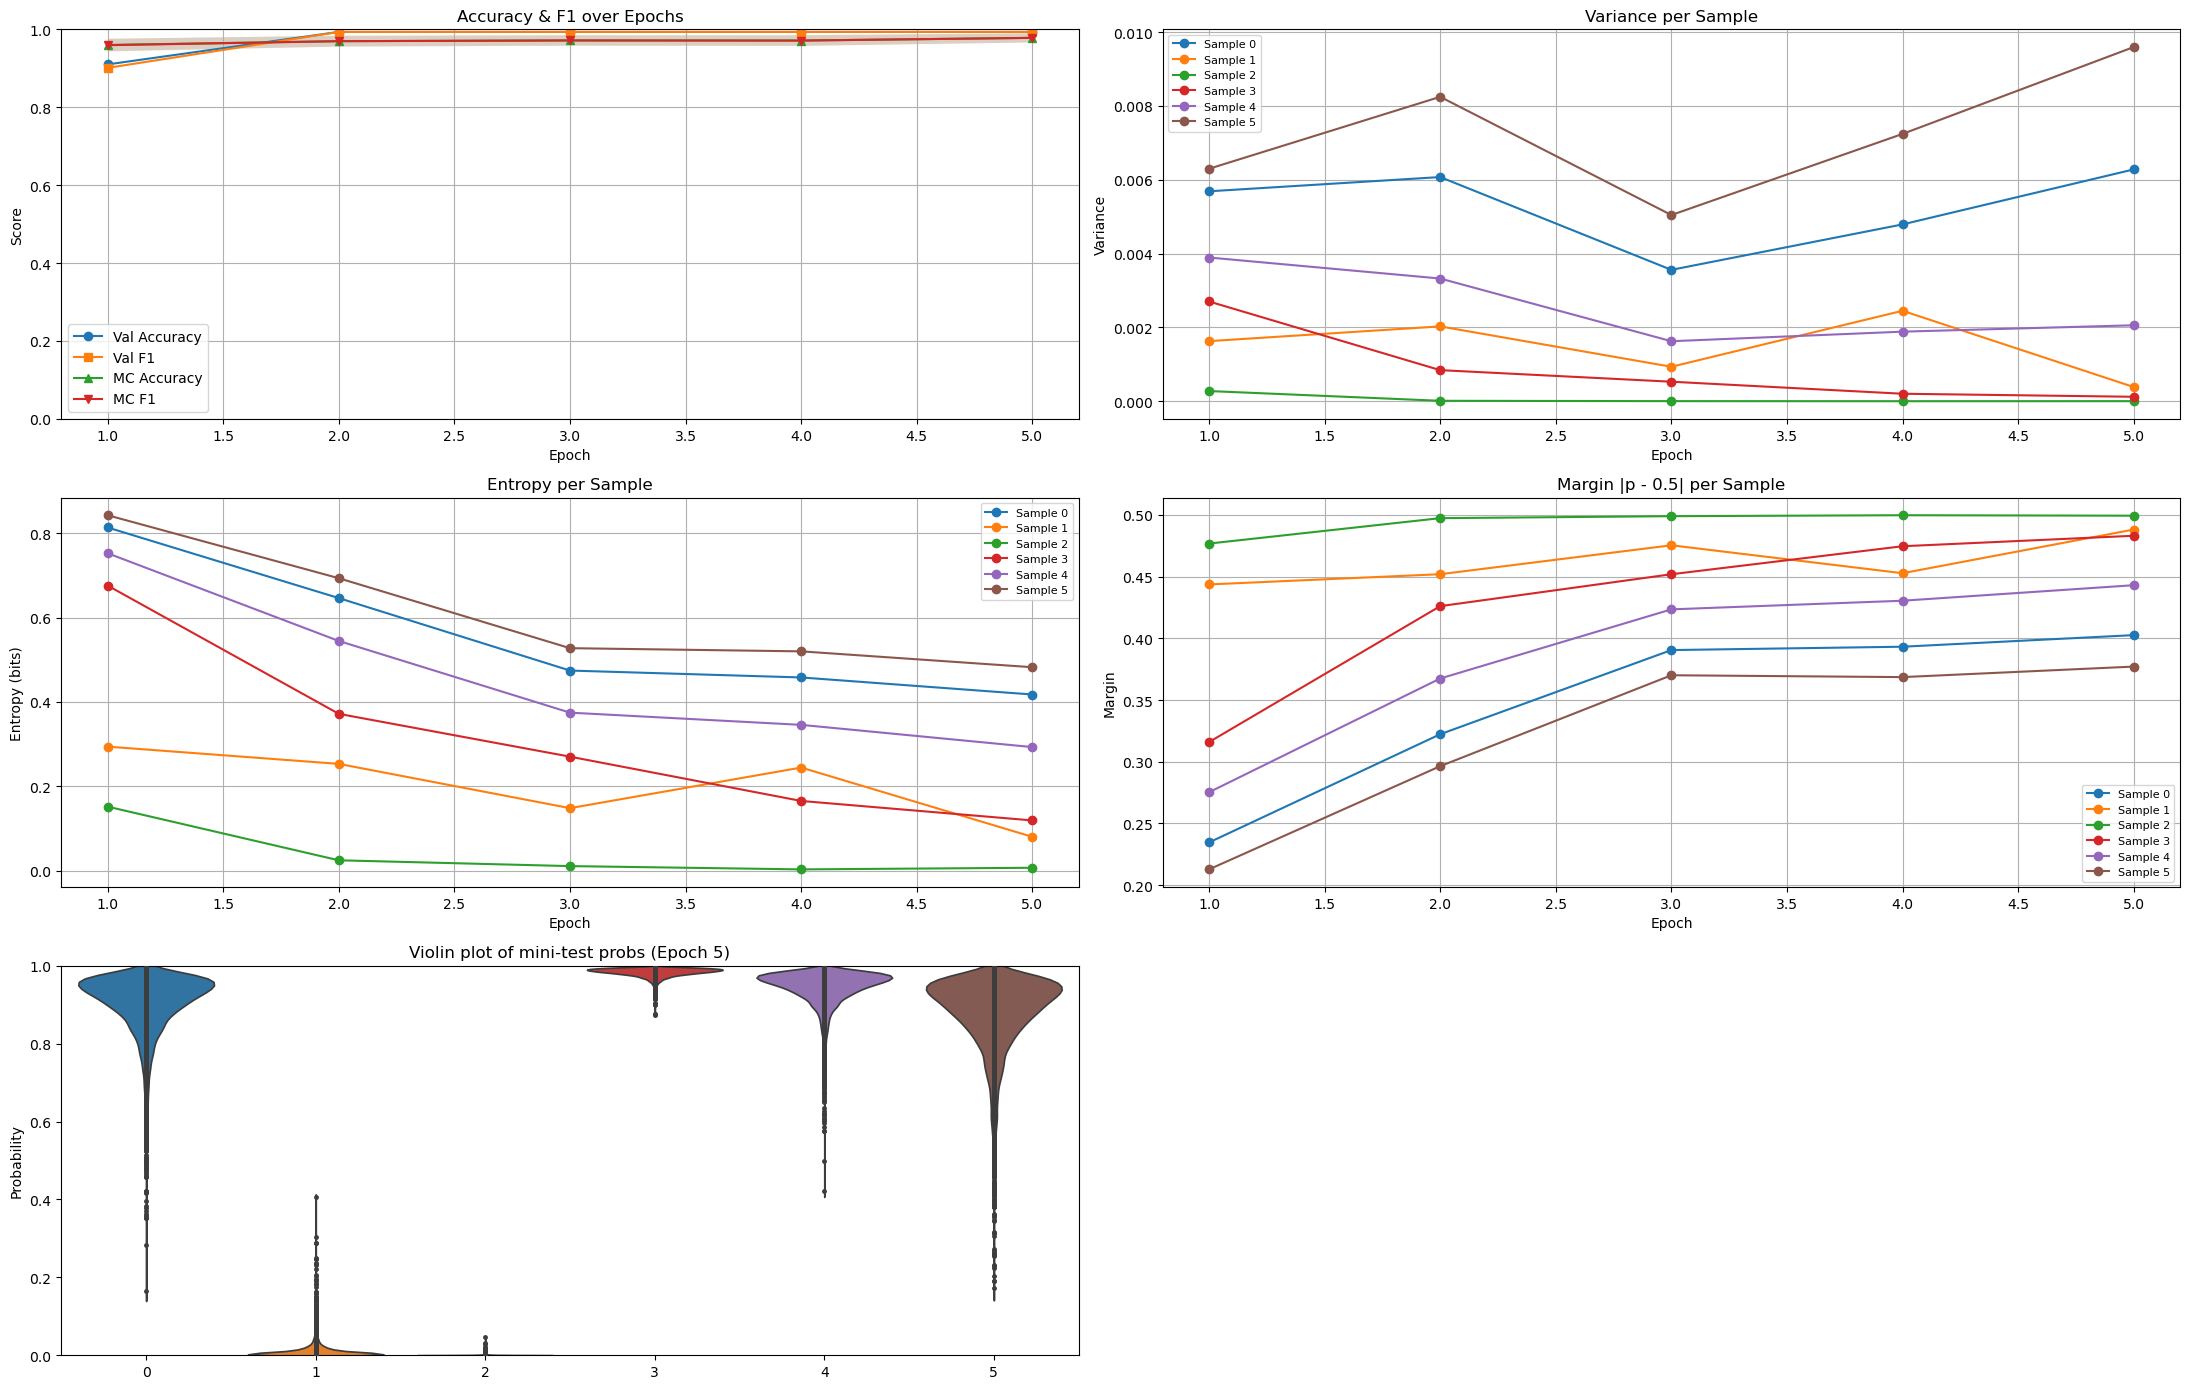

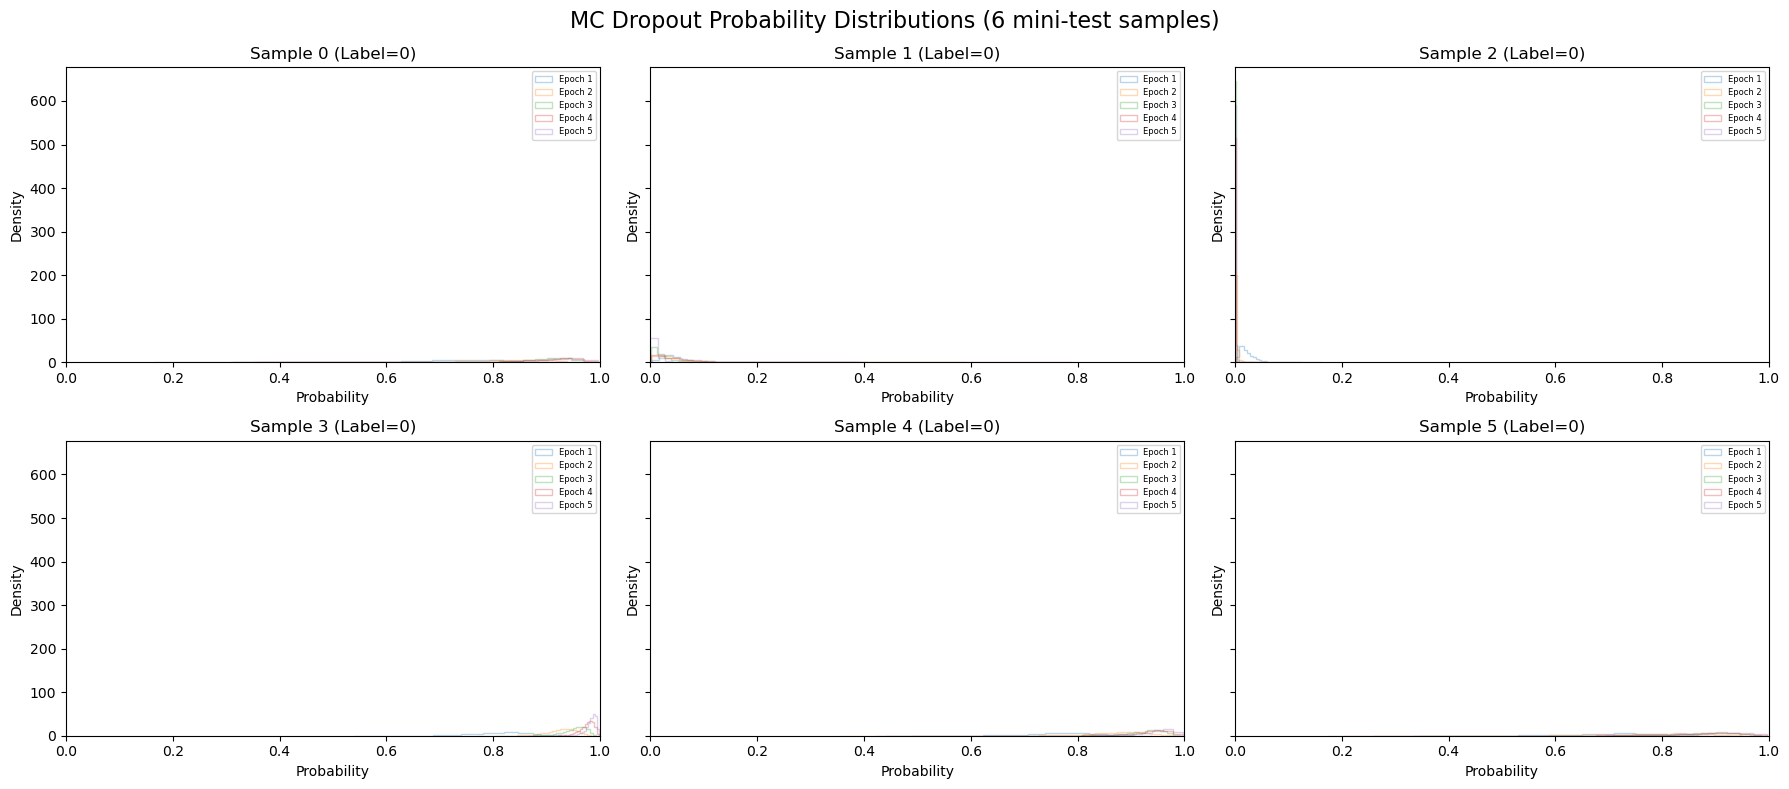

In [20]:
model = MLP(**{'activation': 'relu',
               'batchnorm': True,
               'dropout_p': 0.3,
               'hidden_sizes': (128, 128)}).to('cuda')

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(
            model.parameters(), lr=1e-3, weight_decay=0.0
        )

history = train_model(
        model, 
        train_loader_circles, 
        val_loader_circles,
        mini_circles,
        mini_circles_labels,
        criterion, 
        optimizer, 
        n_epochs=5, 
        device="cuda", 
        use_mc_dropout=True, 
        mc_T=1000
    )

visualize_all(history, model=model, val_loader=val_loader_moons, device="cuda")

### Результаты эксперимента: MC Dropout в бинарной классификации

#### Сравнение Val Accuracy vs MC Accuracy

Анализ кривых показывает, что:
- **MC Accuracy** стабильно занижает значения по сравнению с классическим `val_accuracy`, особенно при более высоких значениях `dropout`.
- Разница между `eval` и `mc_eval` появляется уже после 2-3 эпох и сохраняется на протяжении обучения.
- Это подтверждает, что **MC Dropout помогает избежать переоценки модели и даёт более реалистичную оценку её уверенности**.

#### Анализ распределений вероятностей (по mini-test)

#### Поведение при различных `dropout`:
- При `p = 0.0` (без Dropout) модель выдаёт **узкие и высокие пики**, указывающие на чрезмерную уверенность.
- При `p = 0.2 - 0.6` распределения становятся **более широкими**, отражая рост стохастичности и неопределённости.
- При `p = 1.0` модель фактически **теряет способность к дифференциации классов** - распределения практически плоские и однородные.

#### Метрики неопределённости
- **Variance** и **Entropy** показывают, что сэмплы с низким margin чаще всего соответствуют высоким значениям этих метрик.
- **Margin** - дополнительный признак уверенности: большие значения соответствуют высокой уверенности, малые — неуверенности.

#### Общий вывод
MC Dropout позволяет:
- Оценить **неуверенность нейронной сети** при помощи множественных семплирований.
- Выявить **сложные или неустойчивые примеры**, по которым модель сомневается.
- Избежать переобучения на уверенных предсказаниях.

Таким образом, **использование MC Dropout обогащает анализ модели**, делая её поведение интерпретируемым, особенно в критических областях применения (медицина, автономные системы, финансы и др.).